In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from collections import defaultdict

%load_ext autoreload
%autoreload 2

from utils import *
from net import *
from tokenizer_bpe import *
from coco_captions import *

In [2]:
tokenizer = Tokenizer()
tokenizer.t2i, tokenizer.i2t, tokenizer.bpe_code = torch.load('tokenizer.dat')
tokenizer.t2i = defaultdict(lambda: tokenizer.t2i['<U>'], tokenizer.t2i)
tokenizer.t2i['<U>'] = len(tokenizer.t2i)
tokenizer.i2t = { i: t for t, i in tokenizer.t2i.items() }
tokenizer.NTOK = len(tokenizer.t2i)+10

['A',
 '</w>',
 'man',
 '</w>',
 'in',
 '</w>',
 'a',
 '</w>',
 'red',
 '</w>',
 'shirt',
 '</w>',
 'and',
 '</w>',
 'a',
 '</w>',
 'red',
 '</w>',
 'hat',
 '</w>',
 'is',
 '</w>',
 'on',
 '</w>',
 'a',
 '</w>',
 'motorcycle',
 '</w>',
 'on',
 '</w>',
 'a',
 '</w>',
 'hill',
 '</w>',
 'side',
 '.',
 '</w>']

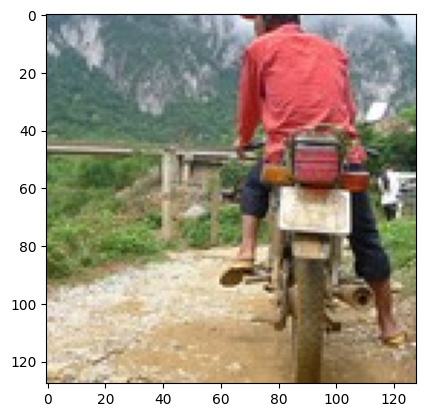

In [3]:
k = 0
plt.imshow(randomcrop(getimg(k), 128))
getcaptions(k)
getRandomEncodedCaption(k)

In [4]:
SX = 128
MAX_LEN = 30

In [5]:
def encode(tokens):
    tokens = ['<S>'] + tokens
    tokens = tokenizer.tokenize(tokens, encd=False)
    x = np.zeros(MAX_LEN+1, dtype=int)
    x[:] = tokenizer.t2i['</S>']
    for k, l in enumerate(tokens[:MAX_LEN+1]):
        x[k] = l
    x = x[:MAX_LEN+1]
    return x



def batchgen(bsize=8):
    ep = 0
    while True:
        inds = np.random.permutation(range(100, N))
        minibatches = [ inds[k*bsize:(k+1)*bsize] for k in range(len(inds)//bsize) ]
        for mb in minibatches:
            xs = np.zeros((bsize, 2048, 7, 7))
            ys = np.zeros((bsize, MAX_LEN+1), dtype=int)
            for i, j in enumerate(mb):
                x = getfeatures(j)
                y = getRandomEncodedCaption(j)
                xs[i] = x
                ys[i] = encode(y)
            yield xs, ys
        print(f'========== EPOCH {ep} COMPLETED ==========')
        ep += 1

bg= batchgen()
next(bg)

(array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 1.97509766e-01, 2.34375000e-01, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [2.70019531e-01, 7.48901367e-02, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [3.16894531e-01, 6.02539062e-01, 3.95019531e-01, ...,
           0.00000000e+00, 3.06640625e-01, 0.00000000e+00],
          [3.32763672e-01, 6.94335938e-01, 1.10742188e+00, ...,
           1.45996094e-01, 8.86718750e-01, 8.62304688e-01]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           1.08398438e-01, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 3.02734375e-01, 0.00000000e+00, ...,
           4.11376953e-02, 0.00000000e+00, 0.00000

In [7]:
from torch_optimizer import Lookahead, Yogi
net = Net(n=128, nh=4, ntok=tokenizer.NTOK)
net.optim = Lookahead(Yogi(net.parameters(), lr=1e-3, betas=(0.9, 0.99)))
net.iters = 0
net.losses = []
net.vlosses = []
bg = batchgen()

net.load_state_dict(torch.load('weights_241223.dat'))

<All keys matched successfully>

In [ ]:
#for m in net.modules():
#    if type(m) == nn.Dropout:
#        m.p = 0.3

In [8]:
def valloss():
    net.eval()
    bsize = 50
    xs = np.zeros((bsize, 2048, 7, 7))
    ys = np.zeros((bsize, MAX_LEN+1), dtype=int)
    for j in range(bsize):
        x = getfeatures(j)
        y = getRandomEncodedCaption(j)
        xs[j] = x
        ys[j] = encode(y)
    xs, ys = np2t(xs, ys)
    yp = net(xs, ys.long())
    ys = ys[:,1:].flatten()
    yp = yp[:,:-1].reshape(-1, tokenizer.NTOK)
    loss  = F.nll_loss(torch.log_softmax(yp, dim=1), ys.long())
    return loss

def Loss():
    net.train()
    xs, ys = next(bg)
    xs, ys = np2t(xs, ys)
    yp = net(xs, ys.long())
    ys = ys[:,1:].flatten()
    yp = yp[:,:-1].reshape(-1, tokenizer.NTOK)
    loss  = F.nll_loss(torch.log_softmax(yp, dim=1), ys.long())
    return loss

valloss(), \
Loss()

(tensor(1.1840, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.0540, device='cuda:0', grad_fn=<NllLossBackward0>))

In [9]:
def lrscheduler(i):
    warmupsteps = 200
    maxlr = 3e-4
    lr = min(maxlr, i/warmupsteps*maxlr)
    for g in net.optim.param_groups:
        g['lr'] = lr

In [ ]:
losses = []
vlosses = []
vmin = 999999

for k in trange(999999):
    net.train()
    lrscheduler(net.iters)
    loss = Loss()
    loss.backward()
    losses.append(loss.item())
    net.optim.step()
    net.optim.zero_grad()
    
    if len(losses) == 500:
        vloss = valloss().item()
        if vloss < vmin:
            vmin = vloss
            torch.save(net.state_dict(), 'weights_251223.dat')
        net.losses.append((net.iters, np.mean(losses)))
        net.vlosses.append((net.iters, vloss))
        losses = []
    net.iters += 1
    
    if k % 500 == 0:
        plt.plot(*zip(*net.losses), zorder=10)
        plt.plot(*zip(*net.vlosses))
        #plt.ylim([0,50])
        plt.grid()
        plt.show()
        im, w, p = predict()
        showimg(im)
        plt.show()
        print(w)
        print(p)

In [11]:
@torch.no_grad()
def predict(k=None, tau=0.1):
    if isinstance(k, type(None)):
        k = np.random.randint(100)
    im = getimg(k)
    xs = np2t([getfeatures(k)])

    ys = np2t([[tokenizer.t2i['<S>']]])
    
    net.eval()
    probs = []
    for i in range(MAX_LEN):
        yp = net(xs, ys.long())
        dist = F.softmax(yp[0,i], dim=0)
        if tau!=0:
            dist2 = t2np(dist)**(1/tau)
            dist2 /= dist2.sum()
            k = np.random.choice(range(tokenizer.NTOK), p=dist2) 
        else:
            k = t2np(yp[0,i]).argmax()
        ys = torch.cat([ys, np2t([[k]])], dim=1).long()
        ys = ys[:,-MAX_LEN:]
        p = dist[k].item()
        probs.append(p)

    p = np.prod(probs)

    ys = t2np(ys[0])
    s = tokenizer.detokenize(ys)
    return im, s, p

In [14]:
predict(0, tau=0.10)[1]

'A man in a red jacket and a hat riding a bike down a dirt '

In [27]:
@torch.no_grad()
def predict_advanced(k=None, tau=0.1):
    if isinstance(k, type(None)):
        k = np.random.randint(100)
    im = getimg(k)
    xs = np2t([getfeatures(k)])

    ys = np2t([[tokenizer.t2i['<S>']]])
    
    net.eval()
    probs = []
    for i in range(MAX_LEN):
        yp = net(xs, ys.long())
        dist = F.softmax(yp[0,i], dim=0)
        if tau!=0:
            dist2 = t2np(dist)**(1/tau)
            dist2 /= dist2.sum()
            k = np.random.choice(range(tokenizer.NTOK), p=dist2) 
        else:
            k = t2np(yp[0,i]).argmax()
        ys = torch.cat([ys, np2t([[k]])], dim=1).long()
        ys = ys[:,-MAX_LEN:]
        p = dist[k].item()
        probs.append(p)

    p = np.prod(probs)

    ys = t2np(ys[0])
    s = [ tokenizer.i2t[y] for y in ys ]
    return im, s, p


from colorama import Back
def print_colored(tokens, k):
    text = ''.join(tokens[:k]) + Back.RED + tokens[k] + Back.RESET + ''.join(tokens[k+1:])
    print(text.replace('</w>', ' '))

A dog is looking at a toilet in a bathroom. </S></S></S></S></S></S></S></S>


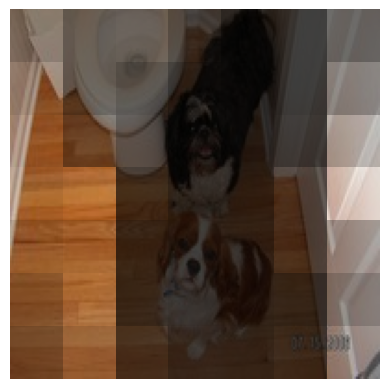

In [108]:
# 5 
k = 18

im, s, p = predict_advanced(42, tau=0)
#im = plt.imread('images/riding_people.png')
print_colored(s, k)
beta = t2np(net.dec3.mha2.beta)[0,1,k].reshape((7,7))
showimg(im)
plt.imshow(0*beta, alpha=.75-beta/beta.max()*.75, extent=(0, 1, 0, 1), cmap='gray');
plt.show()

In [ ]:

plt.imshow(t2np(net.dec1.mha1.beta)[0,2, :30, :30])
plt.xticks(np.arange(30), list(s[:30]));
plt.yticks(np.arange(30), list(s[:30]));